In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import string
from collections import Counter
from keras.preprocessing import text, sequence
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Embedding, Input, Conv1D, Bidirectional, LSTM, GlobalMaxPooling1D, MaxPooling1D, Flatten 
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from scipy.sparse import hstack
import pickle
import gzip
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/Applications/anaconda/lib/python2.7/site-packages/cffi/model.py:532: UserWarning: 'point_conversion_form_t' has no values explicitly defined; guessing that it is equivalent to 'unsigned int'
  % self._get_c_name())


In [2]:
#Reading the file 
df = pd.read_csv('simpsons_dataset.csv')
df.shape

(158314, 2)

In [3]:
#checking for duplicates
df.drop_duplicates()
df.shape

(158314, 2)

In [4]:
# preview the data
df.head(10)

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...
5,Martin Prince,I don't think there's anything left to say.
6,Edna Krabappel-Flanders,Bart?
7,Bart Simpson,Victory party under the slide!
8,NaN,NaN
9,Lisa Simpson,Mr. Bergstrom! Mr. Bergstrom!


In [5]:
# looking at missing values in all the variables
df.apply(lambda x: sum(x.isnull()),axis=0) 

raw_character_text    17814
spoken_words          26459
dtype: int64

In [6]:
# Dropping missing values
df=df.dropna()

In [7]:
# Only 5 classes
classes=['Homer Simpson','Marge Simpson','Bart Simpson','Lisa Simpson']
df.loc[~df['raw_character_text'].isin(classes), 'raw_character_text'] = 'Other'

In [8]:
# preview the data
df.head(10)

,raw_character_text,spoken_words
0,Other,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Other,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Other,The polls will be open from now until the end ...
5,Other,I don't think there's anything left to say.
6,Other,Bart?
7,Bart Simpson,Victory party under the slide!
9,Lisa Simpson,Mr. Bergstrom! Mr. Bergstrom!
10,Other,"Hey, hey, he Moved out this morning. He must h..."


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

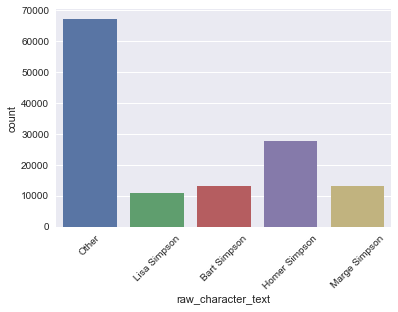

In [9]:
# raw_character_text varibale distribution
sns.countplot(x="raw_character_text", data=df)
plt.xticks(rotation=45)

In [10]:
df["raw_character_text"].value_counts()

Other            67080
Homer Simpson    27850
Marge Simpson    13172
Bart Simpson     12995
Lisa Simpson     10756
Name: raw_character_text, dtype: int64

In [11]:
df_other=df[df["raw_character_text"]=='Other']
df_homer=df[df["raw_character_text"]=='Homer Simpson']
df_minorities=df[(df["raw_character_text"]!='Other') & (df["raw_character_text"]!='Homer Simpson')]

Handling imbalanced dataset by undersampling 'Other' class and 'Homer Simpson' class

In [12]:
df_other_downsampled = resample(df_other, replace=False, n_samples=14000)
df_homer_downsampled = resample(df_homer, replace=False, n_samples=14000)

In [13]:
df = pd.concat([df_minorities, df_other_downsampled, df_homer_downsampled])
df=df.sample(frac=1)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

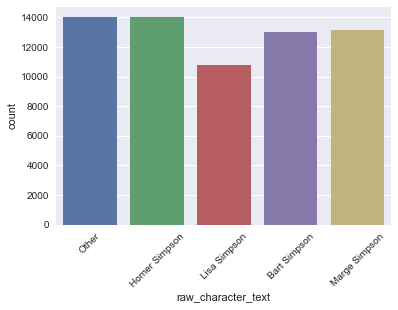

In [14]:
# raw_character_text varibale distribution
sns.countplot(x="raw_character_text", data=df)
plt.xticks(rotation=45)

NLP Features

In [15]:
df['char_count'] = df['spoken_words'].apply(len)
df['word_count'] = df['spoken_words'].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1)
df['punctuation_count'] = df['spoken_words'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df['title_word_count'] = df['spoken_words'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df['upper_case_word_count'] = df['spoken_words'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [16]:
# preview the data
df.head(10)

,raw_character_text,spoken_words,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count
145280,Other,Now we're gonna learn about electricity. Hey l...,68,11,5.666667,4,3,0
76389,Homer Simpson,I love that little shill. Let's get her that d...,51,10,4.636364,3,1,1
20702,Lisa Simpson,POOL MOBILE?!!,14,2,4.666667,3,0,2
155786,Homer Simpson,Listen to Lisa play her sax.,28,6,4.000000,1,2,0
77518,Bart Simpson,I can't just sit here watching this junk.,41,8,4.555556,2,1,1
121191,Lisa Simpson,He's not! He thought he was better than the la...,124,22,5.391304,5,2,0
142190,Other,"Andres Cantor, you know that is incorrect usage!",48,8,5.333333,2,2,0
9284,Bart Simpson,Nope. Metal.,12,2,4.000000,2,2,0
33595,Lisa Simpson,"I don't get it. Straight A's, perfect attendan...",112,19,5.600000,9,5,2
38851,Other,Bart's going to marry the teacher!,34,6,4.857143,2,0,0


In [17]:
X = df.drop(["raw_character_text"], axis=1)
Y = df["raw_character_text"]

In [18]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [19]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [20]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['spoken_words'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x['spoken_words'])
xvalid_count =  count_vect.transform(valid_x['spoken_words'])

In [21]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['spoken_words'])
xtrain_tfidf =  tfidf_vect.transform(train_x['spoken_words'])
xvalid_tfidf =  tfidf_vect.transform(valid_x['spoken_words'])

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(df['spoken_words'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x['spoken_words'])
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x['spoken_words'])

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(df['spoken_words'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x['spoken_words']) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x['spoken_words']) 

In [22]:
# utility function
def train_model(classifier, feature_vector_train, label, feature_vector_valid, valid_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    training_acuracy=classifier.score(feature_vector_train, label)
    print ("Training accuracy:\t"+str(training_acuracy))
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    print ("Validation Accuracy\t"+ str(metrics.accuracy_score(predictions, valid_y)))

In [23]:
# Logistic Regression on Count Vectors
train_model(linear_model.LogisticRegression(penalty='l2', tol=1e-6, C=7.0, solver='lbfgs',  multi_class ='multinomial'), xtrain_count, train_y, xvalid_count, valid_y)

Training accuracy:	0.617101159074
Validation Accuracy	0.372275702734


In [24]:
# Naive Bayes on Count Vectors
train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count, valid_y)

Training accuracy:	0.57383803766
Validation Accuracy	0.383750481325


In [25]:
# Logistic Regression on Word Level TF IDF Vectors
train_model(linear_model.LogisticRegression(solver='lbfgs',  multi_class ='multinomial'), xtrain_tfidf, train_y, xvalid_tfidf, valid_y)

Training accuracy:	0.496669105472
Validation Accuracy	0.385367731998


In [26]:
# Naive Bayes on Word Level TF IDF Vectors
train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf, valid_y)

Training accuracy:	0.487350302283
Validation Accuracy	0.376203311513


In [27]:
# Logistic Regression on Ngram Level TF IDF Vectors
train_model(linear_model.LogisticRegression(solver='lbfgs',  multi_class ='multinomial'), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y)

Training accuracy:	0.441564942816
Validation Accuracy	0.316673084328


In [28]:
# Naive Bayes on Ngram Level TF IDF Vectors
train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y)

Training accuracy:	0.416438830914
Validation Accuracy	0.316673084328


In [29]:
# Logistic Regression on Character Level TF IDF Vectors
train_model(linear_model.LogisticRegression(solver='lbfgs',  multi_class ='multinomial'), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y)

Training accuracy:	0.476895529285
Validation Accuracy	0.386599922988


In [30]:
# Naive Bayes on Character Level TF IDF Vectors
train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y)

Training accuracy:	0.418498979553
Validation Accuracy	0.367886022333


Combining Word Level TF IDF Vectors and Character Level TF IDF Vectors

In [31]:
X_train=hstack([xtrain_tfidf, xtrain_tfidf_ngram_chars]).toarray()

In [32]:
X_valid=hstack([xvalid_tfidf, xvalid_tfidf_ngram_chars]).toarray()

In [33]:
train_model(linear_model.LogisticRegression(solver='lbfgs',  multi_class ='multinomial'), X_train, train_y, X_valid, valid_y)

Training accuracy:	0.550059686549
Validation Accuracy	0.395533307663


Logistic Regression Model using NLP features

In [34]:
xtrain_nlp=train_x[["char_count", "word_count", "word_density", "punctuation_count", "title_word_count", "upper_case_word_count"]].values
xvalid_nlp=valid_x[["char_count", "word_count", "word_density", "punctuation_count", "title_word_count", "upper_case_word_count"]].values

In [35]:
#standardization
sc=StandardScaler()
xtrain_nlp = sc.fit_transform(xtrain_nlp)
xvalid_nlp = sc.transform(xvalid_nlp)
train_model(linear_model.LogisticRegression(solver='lbfgs',  multi_class ='multinomial'), xtrain_nlp, train_y, xvalid_nlp, valid_y)

Training accuracy:	0.249913358235
Validation Accuracy	0.256295725838


Creating polynomial features of degree 3 for NLP features

In [36]:
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=True)
xtrain_nlp_high_dim=poly.fit_transform(xtrain_nlp)
xvalid_nlp_high_dim=poly.fit_transform(xvalid_nlp)

In [37]:
#standardization
sc=StandardScaler()
xtrain_nlp_high_dim = sc.fit_transform(xtrain_nlp_high_dim)
xvalid_nlp_high_dim = sc.transform(xvalid_nlp_high_dim)
train_model(linear_model.LogisticRegression(solver='lbfgs',  multi_class ='multinomial'), xtrain_nlp_high_dim, train_y, xvalid_nlp_high_dim, valid_y)

Training accuracy:	0.257768878278
Validation Accuracy	0.262071621101


Combining Word Level TF IDF features and higher dimensional (degree=3) NLP features

In [38]:
X_train=hstack([xtrain_tfidf,xtrain_nlp_high_dim]).toarray()
X_valid=hstack([xvalid_tfidf,xvalid_nlp_high_dim]).toarray()

In [39]:
#standardization
sc=StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)
train_model(linear_model.LogisticRegression(solver='lbfgs',  multi_class ='multinomial'), X_train, train_y, X_valid, valid_y)

Training accuracy:	0.537621779814
Validation Accuracy	0.367500962649


Combining Word Level TF IDF Vectors, Ngram Level TF IDF Vectors and Character Level TF IDF Vectors

In [40]:
X_train=hstack([xtrain_tfidf, xtrain_tfidf_ngram, xtrain_tfidf_ngram_chars]).toarray()
X_valid=hstack([xvalid_tfidf, xvalid_tfidf_ngram, xvalid_tfidf_ngram_chars]).toarray()
dummy_train_y=np_utils.to_categorical(train_y)

A neural network with two hidden layers

In [41]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))
classifier.add(Dropout(p = 0.5))

# Adding the second hidden layer
classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(p = 0.5))

# Adding the output layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train,dummy_train_y, validation_data=(X_valid,np_utils.to_categorical(valid_y)), batch_size = 128, epochs = 2)

Train on 51938 samples, validate on 12985 samples
Epoch 1/2
51938/51938 [==============================] - 57s 1ms/step - loss: 1.4881 - acc: 0.3377 - val_loss: 1.3899 - val_acc: 0.4007

A recent approach for text classification is by treating each dialogue as an image of depth 1 and subsequently using Convolutional Neural Networks (CNN) to classify the images. This trasformation of the dialogue can be achieved by tokenizing the sentence and subsequently using an embedding layer whose weights are also trained along with the model. The first model shown here is a simple CNN but it turns out that the pooling layers drastically detoriates the model whereas without the pooling layers the model performs reasonably well.

In [42]:
texts=df['spoken_words'].tolist()
labels=df['raw_character_text'].tolist()
labels=encoder.fit_transform(labels)

In [43]:
MAX_NB_WORDS=8000
MAX_SEQUENCE_LENGTH=1000
VALIDATION_SPLIT=0.2
EMBEDDING_DIM=100
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = np_utils.to_categorical(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Found 27305 unique tokens.
('Shape of data tensor:', (64923, 1000))
('Shape of label tensor:', (64923, 5))


In [45]:
embedding_layer = Embedding(len(word_index) + 1,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 3, activation='relu')(embedded_sequences)
#x = MaxPooling1D(3)(x)
#x = Conv1D(128, 5, activation='relu')(x)
#x = MaxPooling1D(5)(x)
x = Conv1D(128, 3, activation='relu')(x)
#x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(5, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=2, batch_size=256)

Train on 51939 samples, validate on 12984 samples
Epoch 1/2
51939/51939 [==============================] - 821s 16ms/step - loss: 1.6195 - acc: 0.2649 - val_loss: 1.4693 - val_acc: 0.3384

Next, I have implemented a bidirectional LSTM layer with latent dimension 100. LSTM is able to remember long term dependencies unlike other naive models and is performing reasonbly well. (although not as good as the simple ANN)

In [46]:
embedding_layer3 = Embedding(len(word_index) + 1,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH)
sequence_input3 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences3 = embedding_layer3(sequence_input3)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences3)
preds = Dense(5, activation='softmax')(l_lstm)
model = Model(sequence_input3, preds)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
print("model fitting - Bidirectional LSTM")
model.summary()
model.fit(x_train, y_train, validation_data=(x_val, y_val),nb_epoch=2, batch_size=256)

model fitting - Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 100)         2730600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 1005      
Total params: 2,892,405
Trainable params: 2,892,405
Non-trainable params: 0
_________________________________________________________________
Train on 51939 samples, validate on 12984 samples
Epoch 1/2
51939/51939 [==============================] - 2211s 43ms/step - loss: 1.5902 - acc: 0.2844 - val_loss: 1.5641 - val_acc: 0.2847

The best model is the artificial neural network with 2 hidden layers. So, I am using the entire dataset to train the model. But before that I am treating 100 least frequent words as out of vocabulary words and replacing them with "OOV". This is done to deal with new words in the test data while prediction. Finally I am storing the model on disk.  

In [47]:
# creating Vocabulary
Vocabulary=Counter([y for x in df['spoken_words'] for y in x.split()])

In [48]:
# a utility function to find 100 least frequent words 
def least_common_words(vocabulary):
    oov={}
    count=0
    for key, value in sorted(vocabulary.iteritems(), key=lambda (k,v): (v,k)):
        count+=1
        if count<=100:
            oov[key]="OOV"
    return oov

In [49]:
oov=least_common_words(Vocabulary)
oov2 = {r'(\b){}(\b)'.format(k):r'\1{}\2'.format(v) for k,v in oov.items()}
# replacing least frequent words in dataframe with "OOV"
df['spoken_words'] = df['spoken_words'].replace(oov2, regex=True)

In [50]:
X = df["spoken_words"]
Y = df["raw_character_text"]

In [51]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
Y = encoder.fit_transform(Y)

In [52]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(X)
xtrain_tfidf =  tfidf_vect.transform(X)
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(X)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X)
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(X)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X)

In [53]:
# Combining Word Level TF IDF Vectors, Ngram Level TF IDF Vectors and Character Level TF IDF Vectors
X_train=hstack([xtrain_tfidf, xtrain_tfidf_ngram, xtrain_tfidf_ngram_chars]).toarray()
dummy_train_y=np_utils.to_categorical(Y)

In [54]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))
classifier.add(Dropout(p = 0.5))

# Adding the second hidden layer
classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(p = 0.5))

# Adding the output layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, dummy_train_y, batch_size = 128, epochs = 2)

Epoch 1/2
64923/64923 [==============================] - 68s 1ms/step - loss: 1.4719 - acc: 0.3460

In [55]:
# creating a dictionary that needs to be stored for prediction
dic={}
dic["Vocabulary"]=Vocabulary
dic["tfidf_vect"]=tfidf_vect
dic["tfidf_vect_ngram"]=tfidf_vect_ngram
dic["tfidf_vect_ngram_chars"]=tfidf_vect_ngram_chars
dic["encoder"]=encoder

In [57]:
# Saving the best model to disk
classifier.save('my_trained_model.h5')
path_to_model="./"
f = gzip.open(path_to_model+'dictionary.pklz','wb')
pickle.dump(dic,f)
f.close()